---
sidebar_position: 3
---

# Switches and transitions
 
A lot of signals can have anomalies and special events that happen on specific timeframes: 
- a promotion gives a temporary boost in sales
- an outage results in a loss of 90% of the data volume
- a device gets broken and generates more noise
- the creation of a new shop adds a new linear trend to the revenue of a company 
- a holiday makes a seasonality pattern change

These events can happen in two ways:
- the signal suddenly changes: **instant change**.
- the signal gradually changes to reach a new value: **change with transition period**.

In **mockseries**, this kind of change is called a **switch**. 
Let's see how to create such switches, and how to create custom transitions. 

## Switch and revert

Consider a simple switch: the base value is 0, and it changes to 1 after 2 days.

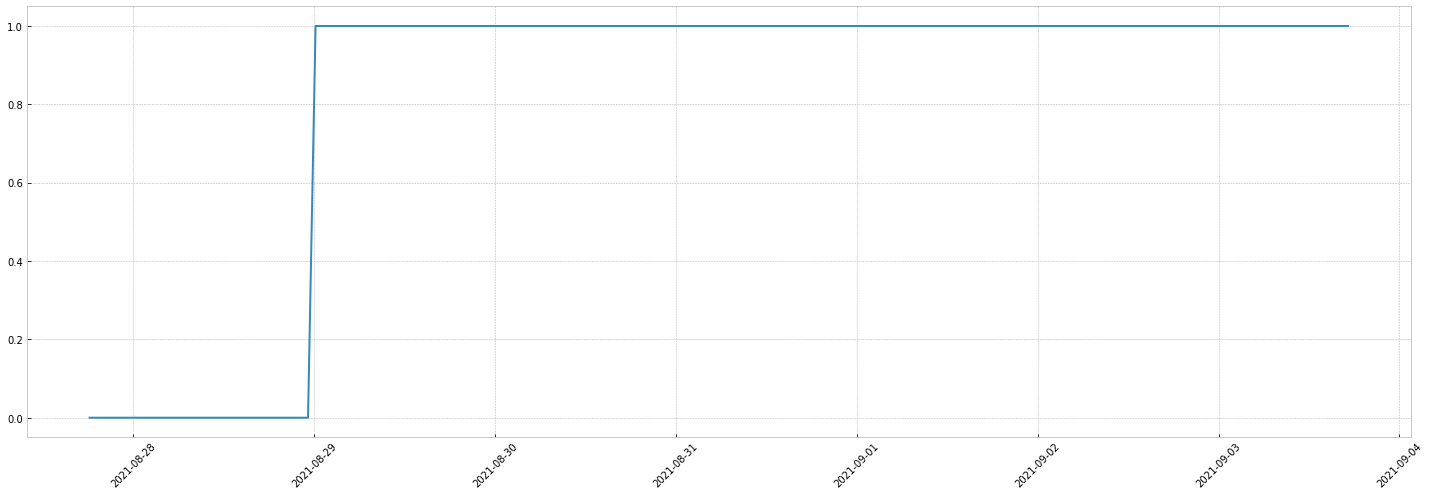

In [1]:
from datetime import datetime, timedelta

# plotting utilities for the whole tutorial 
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20,7)

from mockseries.trend import Switch

today_midnight = datetime.combine(datetime.now().date(), datetime.min.time())

switch = Switch(
    start_time=today_midnight + timedelta(days=2),
    base_value=0, 
    switch_value=1,
    )
switch.preview_week()   

You can configure the switch to revert to the base value.  
Let's revert 2 days after the change.

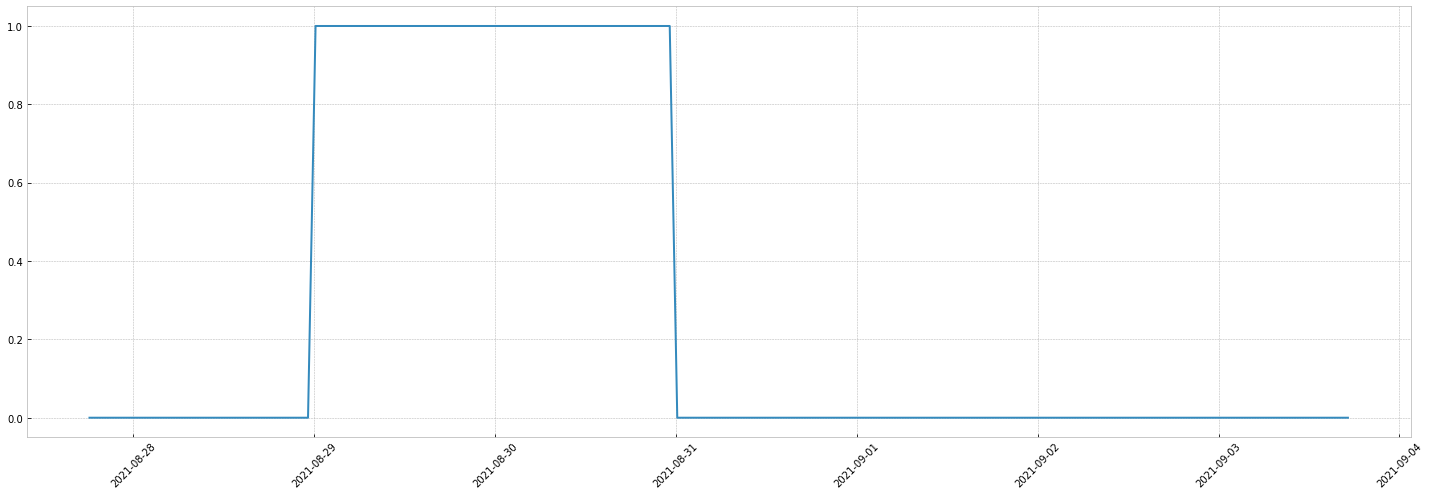

In [2]:
switch_and_revert = Switch(
    start_time=today_midnight + timedelta(days=2),
    base_value=0, 
    switch_value=1,
    stop_time=today_midnight + timedelta(days=4),
    )
switch_and_revert.preview_week()  

Thanks to signal combinations, this simple switch allows powerful simulations, for instance:  

- the opening of a new shop adds a new constant value to the revenue of a company 

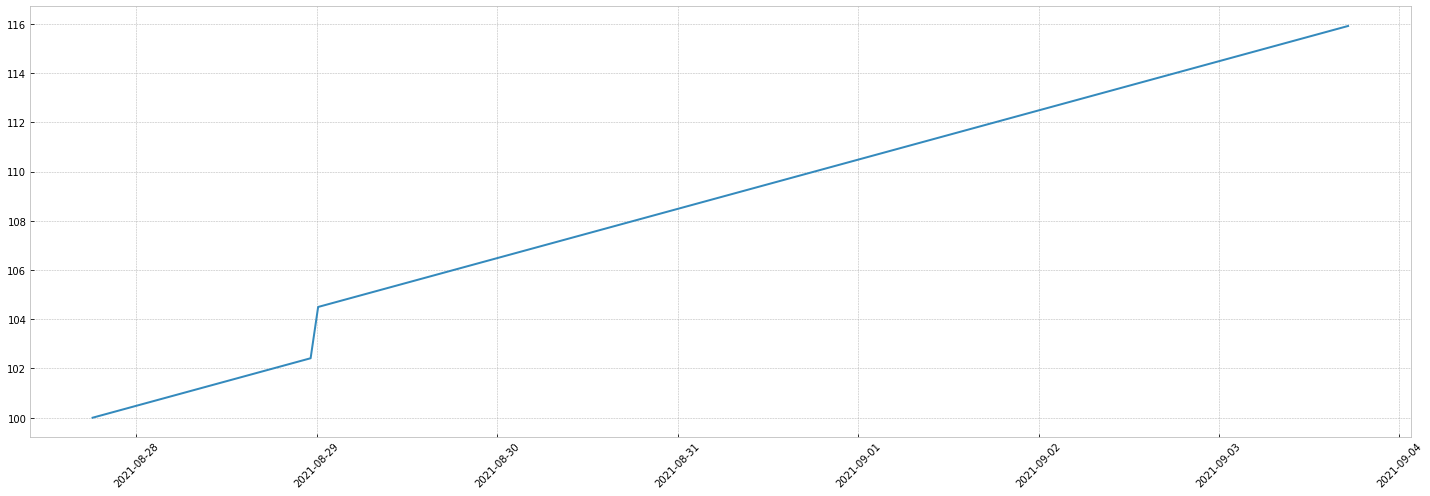

In [3]:
from mockseries.trend import LinearTrend

previous_revenue = LinearTrend(coefficient=2, time_unit=timedelta(days=1), flat_base=100)
new_revenue = 2
revenue_signal = previous_revenue + (new_revenue * switch)

revenue_signal.preview_week()


- a device gets broken, it generates noise, then is fixed: 

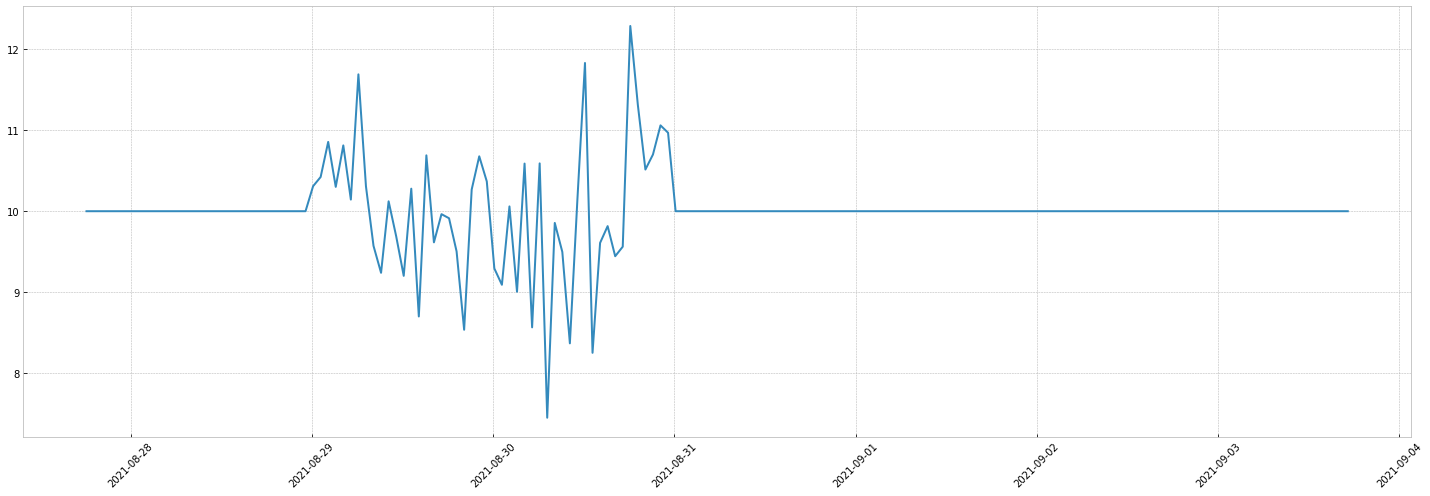

In [4]:
from mockseries.noise import GaussianNoise
usual_device_value = 10  ## brodcasted to flat trend
noise = GaussianNoise()

signal_with_broken_device = usual_device_value + switch_and_revert * noise

signal_with_broken_device.preview_week()

- an outage results in a loss of 90% of a seasonal data volume.

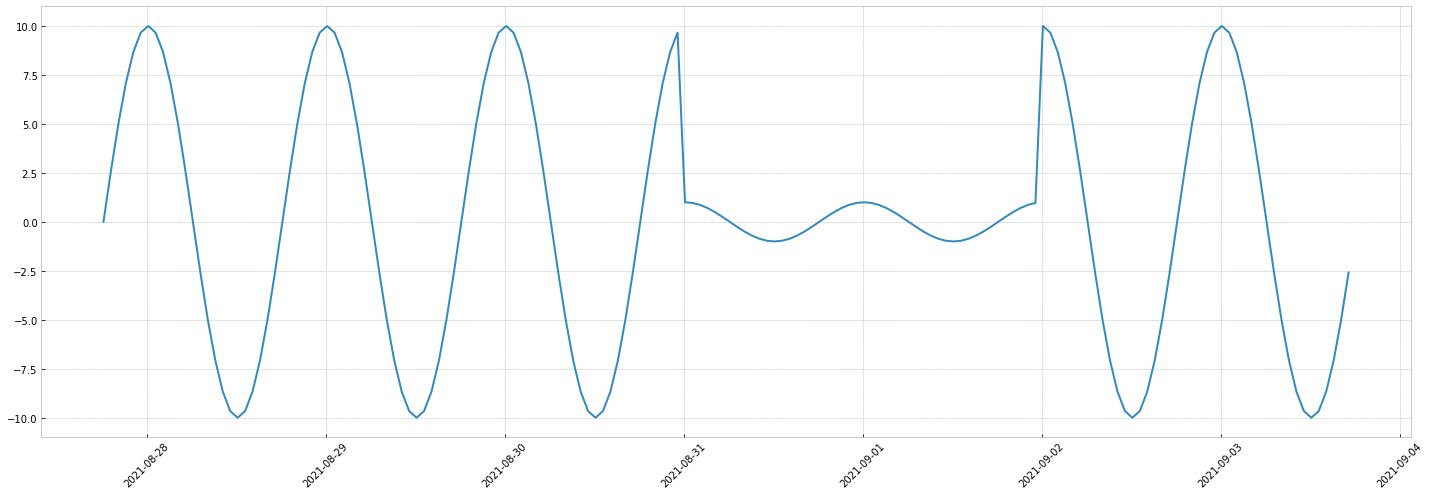

In [5]:
from mockseries.seasonality import SinusoidalSeasonality

usual_volume = SinusoidalSeasonality(amplitude=10, period=timedelta(days=1))

outage_switch = Switch(
    start_time=today_midnight + timedelta(days=4),
    base_value=1, 
    switch_value=0.1,
    stop_time=today_midnight + timedelta(days=6),
    )
volume_with_outage = usual_volume * outage_switch

volume_with_outage.preview_week()

## Transitions
For the moment, we've only seen **instant transitions**. This is the default behavior of the [Switch](../API%20Reference/mockseries/trend/switch).  
In real life, many change events have specific transitions behavior.
Imagine you drive at 90km/hour, and you enter an highway: you change your speed to 130km/hour. 
At the end of the highway, you get back to 90km/hour. These changes are definitely not instant ! You accelerate: this is the transition.

A transition has:
- a window: for the car example, it's the time to change from 90 to 130k/hour
- a transition function: the shape of the change from 90 to 130km/hour (it most likely is not linear)   
Those depends on the car and the way you drive.   

### Linear transition
First, let's consider the acceleration of the car is linear.

The timeseries will be:
- car is at 90km/hour
- car accelerates **linearly**, it reaches 130km/hour in **10 seconds**
- car is at 130km/hour
- car decelerates **linearly**, reaches 90km/hour in **5 seconds**
- car is at 90km/hour

To implement this in **mockseries**, we pass a [Transition](../API%20Reference/mockseries/transition/transition) object to the switch signal. 
The [Transition](../API%20Reference/mockseries/transition/transition) describes the time and the shape of the transition.  

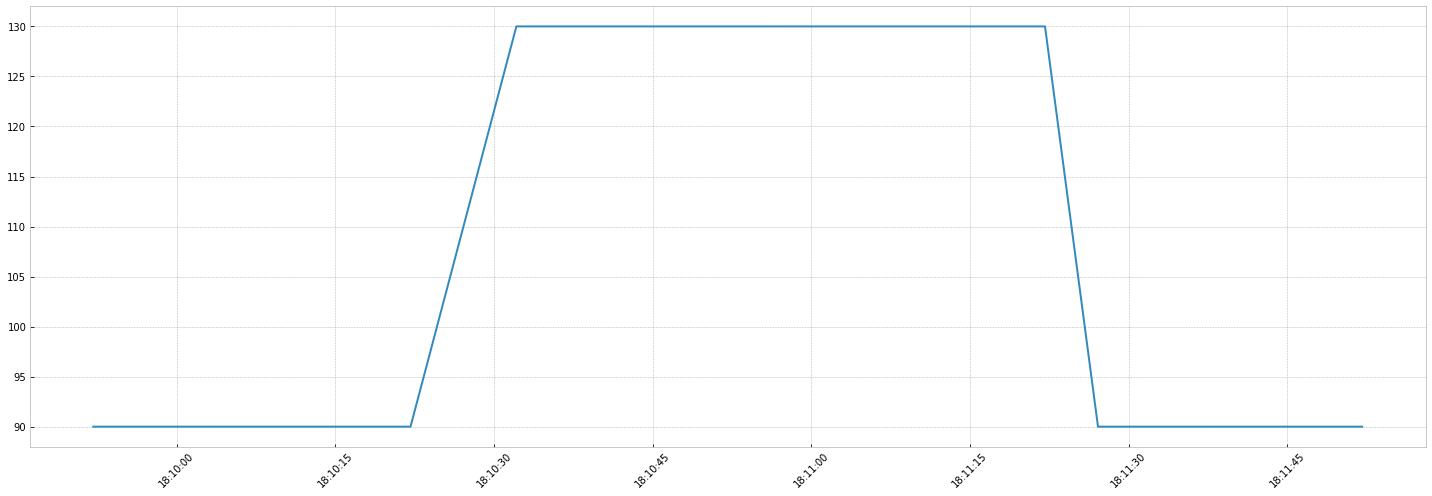

In [6]:
from mockseries.transition import LinearTransition

linear_transition = LinearTransition(
    transition_window=timedelta(seconds=10),
    stop_window=timedelta(seconds=5),
)

now = datetime.now()

speed_switch = Switch(
    start_time=now + timedelta(seconds=30),
    base_value=90, 
    switch_value=130,
    stop_time=now + timedelta(minutes=1, seconds=30),
    transition=linear_transition
    )

speed_switch.preview_minute(num_minutes=2)

### Lambda transition
Above looks nice, but we want to use more complex transitions.
The [LambdaTransition](../API%20Reference/mockseries/transition/lambda_transition) allows to use custom transition functions.

The key idea of the lambda transition is that the transition behavior can be defined as a function such as 
$t(0) = 0$  (the very beginning of the transition) and $t(1) = 1$ (the  end of the transition). 
This transition function is then rescaled to take into account the transition time and the base and switch values.  
You just need a rough shape of the transition and define it on a \[0-1\] range.   

Let's take the car example with:
- a perfect, smooth acceleration: accelerate a lot at the beginning then reach the new speed slowly    
$acceleration(x) = 1 - (1-x)**4$  
- a brutal deceleration: decelerate too much, then get back to the base speed  
$deceleration(x) = 3.11111 * x^3 - 7.86667 * x^2 + 5.75556 * x$  (believe me for this one)

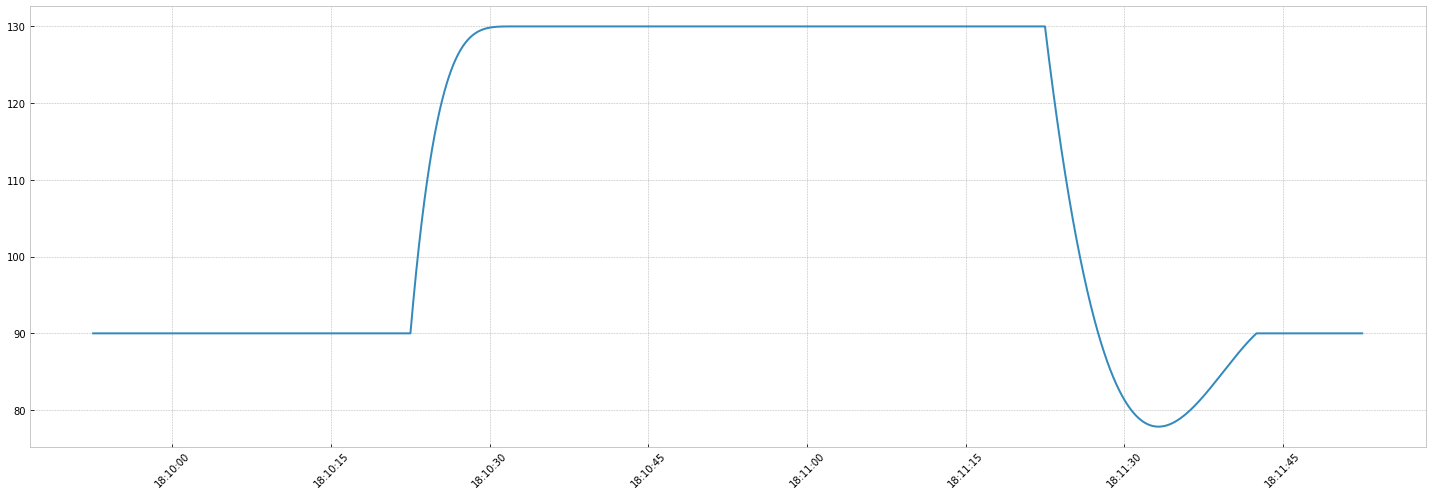

In [7]:
from mockseries.transition  import LambdaTransition 

acceleration = lambda x : 1 - (1-x)**4
deceleration = lambda x: 3.11111 * x**3 - 7.86667 * x**2 + 5.75556 * x

realistic_transition = LambdaTransition(
    transition_window=timedelta(seconds=10),
    transition_function=acceleration,
    stop_window=timedelta(seconds=20),
    stop_function=deceleration
)

now = datetime.now()

realistic_speed = Switch(
    start_time= now + timedelta(seconds=30),
    base_value=90, 
    switch_value=130,
    stop_time=now + timedelta(minutes=1, seconds=30),
    transition=realistic_transition
    )

realistic_speed.preview_minute(num_minutes=2)

That's it! You now know how to:
- define switches
- define complex transitions 

To go further:
- implement more realistic transitions function (checkout some automotive course)
- change the transition window size and see how it impacts the timeseries 

Go to the next page to explore random switches. This is helpful to simulate random outages.